## Example of 2D Graph Modality 

Here we provide the example code for exploring the neural scaling law of 2D Graph Modality with GIN backbone. You can easily compare this example to other modality (Fingerprint, SMILES string and 3D graph) since we use similar code framework.  

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader
from splitter import random_split


from datasets.molnet import MoleculeDataset
from model.gnn import GNN
from model.mlp import MLP

### 1. Define the basic functions we need to use.

In [2]:
def seed_all(seed):
    if not seed:
        seed = 0
    print("[ Using Seed : ", seed, " ]")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    return

def get_num_task(dataset):
    # Get output dimensions of different tasks
    if dataset == 'tox21':
        return 12
    elif dataset in ['hiv', 'bace', 'bbbp']:
        return 1
    elif dataset == 'muv':
        return 17
    elif dataset == 'toxcast':
        return 617
    elif dataset == 'sider':
        return 27
    elif dataset == 'clintox':
        return 2
    elif dataset == 'pcba':
        return 92
    raise ValueError('Invalid dataset name.')

seed = 0
seed_all(seed)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


[ Using Seed :  0  ]


### 2. Load dataset and partition it with random split. You can also easily replace it with other split methods (scaffold and imbalanced).

In [3]:
dataset_name = 'hiv'
split = 'random'
num_tasks = get_num_task(dataset_name)
# Set your dataset directory
dataset_folder = '/home/YourDir/datasets/molecule_net/'
dataset = MoleculeDataset(dataset_folder + dataset_name, dataset=dataset_name)

print(dataset)
eval_metric = roc_auc_score

if split == 'random':
    smiles_list = pd.read_csv(dataset_folder + dataset_name + '/processed/smiles.csv',
                                header=None)[0].tolist()
    train_dataset, valid_dataset, test_dataset, (train_smiles, valid_smiles, test_smiles),_ = random_split(
        dataset, null_value=0, frac_train=0.8, frac_valid=0.1,
        frac_test=0.1, seed=42, smiles_list=smiles_list)
    print('randomly split')
    
else:
    raise ValueError('Invalid split option.')
print(train_dataset[0])
print('Training data length: {}'.format(len(train_smiles)))     

Dataset: hiv
Data: Data(x=[1049163, 2], edge_index=[2, 2259376], edge_attr=[2259376, 2], id=[41127], fingerprint=[41127, 1024], y=[41127])
MoleculeDataset(41127)
randomly split
Data(y=[1], x=[39, 2], edge_index=[2, 84], fingerprint=[1, 1024], edge_attr=[84, 2], id=[1])
Training data length: 32901


### 3. Randomly select partial training set (1%, 5%, 10%, ..., 100%) for model training. 

In [4]:
finetune_ratio = 0.01
batch_size = 256
finetune_num = int(finetune_ratio * len(train_smiles))
num_mols = len(train_dataset)
random.seed(seed)
all_idx = list(range(num_mols))
random.shuffle(all_idx)
ids = all_idx[:int(finetune_ratio * num_mols)]
train_dataset = train_dataset[ids]

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=8)

### 4. Setup backbone model and optimizer

In [5]:
num_layer = 5
emb_dim = 300
dropout_ratio = 0.5
lr = 1e-3

model_param_group = []
model = GNN(num_layer=num_layer, emb_dim=emb_dim, drop_ratio=dropout_ratio).to(device)
output_layer = MLP(in_channels=emb_dim, hidden_channels=emb_dim, 
                    out_channels=num_tasks, num_layers=1, dropout=0).to(device)

model_param_group.append({'params': output_layer.parameters(),'lr': lr})
model_param_group.append({'params': model.parameters(), 'lr': lr})

print(model)                
optimizer = optim.Adam(model_param_group, lr=lr, weight_decay=0)

GNN(
  (x_embedding1): Embedding(120, 300)
  (x_embedding2): Embedding(3, 300)
  (gnns): ModuleList(
    (0): GINConv()
    (1): GINConv()
    (2): GINConv()
    (3): GINConv()
    (4): GINConv()
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### 5. Train and evaluate the model.

In [6]:
criterion = nn.BCEWithLogitsLoss(reduction='none')
train_roc_list, val_roc_list, test_roc_list = [], [], []
train_loss_list, val_loss_list, test_loss_list = [], [], []
roc_lists = []
best_val_roc, best_val_idx = -1, 0
optimal_loss = 1e10

def train_general(model, device, loader, optimizer):
    model.train()
    total_loss = 0

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        h = global_mean_pool(model(batch), batch.batch)
        pred = output_layer(h)
        
        y = batch.y.view(pred.shape).to(torch.float64)
        is_valid = y ** 2 > 0
        loss_mat = criterion(pred.double(), (y + 1) / 2)
        loss_mat = torch.where(
            is_valid, loss_mat,
            torch.zeros(loss_mat.shape).to(device).to(loss_mat.dtype))
        
        optimizer.zero_grad()
        loss = torch.sum(loss_mat) / torch.sum(is_valid)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()

    global optimal_loss 
    temp_loss = total_loss / len(loader)
    if temp_loss < optimal_loss:
        optimal_loss = temp_loss

    return total_loss / len(loader)


def eval_general(model, device, loader):
    model.eval()
    y_true, y_scores = [], []
    total_loss = 0

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        with torch.no_grad():
            h = global_mean_pool(model(batch), batch.batch)
            pred = output_layer(h)
    
        true = batch.y.view(pred.shape)

        y_true.append(true)
        y_scores.append(pred)


    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_scores = torch.cat(y_scores, dim=0).cpu().numpy()

    roc_list = []
    for i in range(y_true.shape[1]):
        # AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:, i] == 1) > 0 and np.sum(y_true[:, i] == -1) > 0:
            is_valid = y_true[:, i] ** 2 > 0
            roc_list.append(eval_metric((y_true[is_valid, i] + 1) / 2, y_scores[is_valid, i]))
        else:
            print('{} is invalid'.format(i))

    if len(roc_list) < y_true.shape[1]:
        print(len(roc_list))
        print('Some target is missing!')
        print('Missing ratio: %f' %(1 - float(len(roc_list)) / y_true.shape[1]))

    return sum(roc_list) / len(roc_list), total_loss / len(loader), roc_list

In [7]:
epochs = 100

train_func = train_general
eval_func = eval_general

for epoch in range(1, epochs + 1):
    loss_acc = train_func(model, device, train_loader, optimizer)
    print('Epoch: {}\nLoss: {}'.format(epoch, loss_acc))

    train_roc = train_loss = 0
    
    val_roc, val_loss, _ = eval_func(model, device, val_loader)
    test_roc, test_loss, roc_list = eval_func(model, device, test_loader)

    train_roc_list.append(train_roc)
    val_roc_list.append(val_roc)
    test_roc_list.append(test_roc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    test_loss_list.append(test_loss)
    roc_lists.append(roc_list)
    print('val: {:.6f}\ttest: {:.6f}'.format(val_roc, test_roc))
    print()

    if val_roc > best_val_roc:
        best_val_roc = val_roc
        best_val_idx = epoch - 1

Epoch: 1
Loss: 0.7890448979555018
val: 0.493066	test: 0.467586

Epoch: 2
Loss: 0.7206984094669178
val: 0.521066	test: 0.567369

Epoch: 3
Loss: 0.6808990557626126
val: 0.546758	test: 0.583905

Epoch: 4
Loss: 0.6745207162534314
val: 0.571512	test: 0.604082

Epoch: 5
Loss: 0.6650212782655167
val: 0.555260	test: 0.630019

Epoch: 6
Loss: 0.6609979158821531
val: 0.552788	test: 0.629470

Epoch: 7
Loss: 0.6365597884904656
val: 0.545063	test: 0.609288

Epoch: 8
Loss: 0.6325839394666748
val: 0.558695	test: 0.598746

Epoch: 9
Loss: 0.6194784707871628
val: 0.560854	test: 0.613101

Epoch: 10
Loss: 0.6119444207838427
val: 0.545393	test: 0.587247

Epoch: 11
Loss: 0.6084267317479832
val: 0.546163	test: 0.584681

Epoch: 12
Loss: 0.594379795679181
val: 0.550446	test: 0.580790

Epoch: 13
Loss: 0.5814032406936134
val: 0.558260	test: 0.591325

Epoch: 14
Loss: 0.5821246152011825
val: 0.572061	test: 0.609039

Epoch: 15
Loss: 0.5623563324240084
val: 0.572713	test: 0.608568

Epoch: 16
Loss: 0.5629411729916913


In [10]:
print('best val: {:.6f}\ttest: {:.6f}'.format(val_roc_list[best_val_idx], test_roc_list[best_val_idx]))

best val: 0.663913	test: 0.664687


### 6. Gather the results from 5 independent runs. 
Here we omit the results from the other runs and provid the integrated results from three classfication tasks (HIV, MUV and PCBA). 

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

hiv = np.array([
    [0.5896, 0.6812, 0.7460, 0.7774, 0.7768, 0.7998, 0.8310, 0.8411, 0.8531],
    [0.6647, 0.7389, 0.7801, 0.7874, 0.8040, 0.8039, 0.8279, 0.8237, 0.8710],
    [0.6258, 0.7037, 0.7090, 0.8054, 0.7857, 0.7734, 0.8187, 0.8396, 0.8412],
    [0.6458, 0.6869, 0.7464, 0.7768, 0.7636, 0.7932, 0.8067, 0.8415, 0.8501],
    [0.6432, 0.6805, 0.7669, 0.7776, 0.8186, 0.7801, 0.7892, 0.8428, 0.8326]
])
muv = np.array([
    [0.4381, 0.5454, 0.5818, 0.6727, 0.7621, 0.6712, 0.7054, 0.7617, 0.8068],
    [0.5378, 0.6388, 0.6178, 0.7187, 0.7038, 0.7215, 0.7386, 0.7834, 0.8024],
    [0.4707, 0.5556, 0.5380, 0.6610, 0.6668, 0.7252, 0.7222, 0.7891, 0.8183],
    [0.4498, 0.5724, 0.5653, 0.6855, 0.6907, 0.6618, 0.7230, 0.7255, 0.7780],
    [0.4755, 0.6006, 0.6749, 0.7079, 0.7379, 0.7317, 0.7554, 0.8083, 0.7814]
])
pcba = np.array([
    [0.0524, 0.0958, 0.1296, 0.1750, 0.1961, 0.2161, 0.2468, 0.2673, 0.2829],
    [0.0502, 0.0942, 0.1339, 0.1823, 0.2087, 0.2303, 0.2534, 0.2733, 0.2809],
    [0.0526, 0.0961, 0.1339, 0.1691, 0.1912, 0.2161, 0.2443, 0.2625, 0.2735],
    [0.0512, 0.0952, 0.1302, 0.1836, 0.2048, 0.2203, 0.2551, 0.2662, 0.2791],
    [0.0542, 0.0995, 0.1327, 0.1775, 0.2000, 0.2262, 0.2448, 0.2713, 0.2794]
])
data_list = [hiv, muv, pcba]

### 7. Fit the curve and plot the neural scaling law.

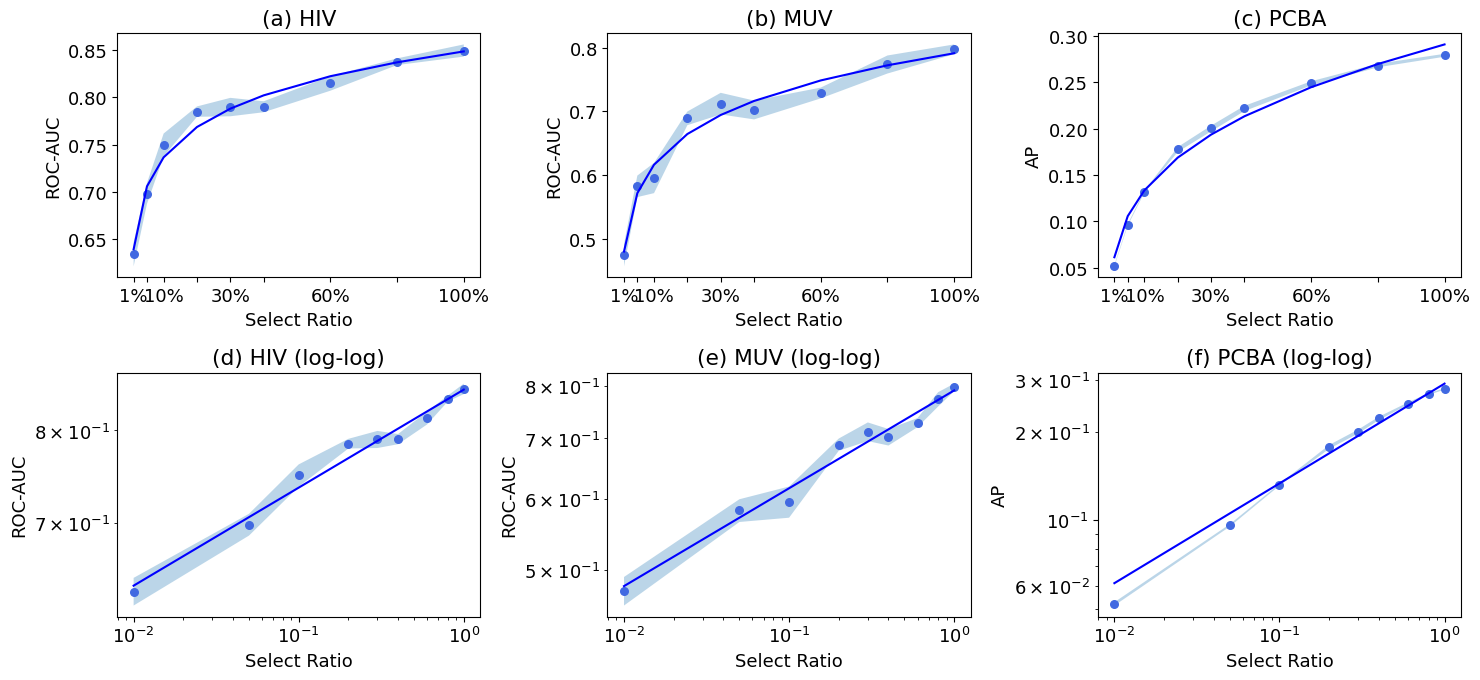

In [24]:
def power_law(x, a, b):
    return a * np.power(x, b)

fig, axs = plt.subplots(2, 3, figsize=(15, 7))
x = [0.01,0.05,0.1,0.2,0.3,0.4,0.6,0.8,1]

for i,data in enumerate(data_list):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    params, _ = curve_fit(power_law, x, mean)

    mean_data = np.mean(data, axis=0)
    std_data = np.std(data, axis=0) / 2
    max_data = mean_data + std_data
    min_data = mean_data - std_data

    axs[0][i].fill_between(x, max_data, min_data, alpha=0.3)
    axs[0][i].scatter(x, mean_data, marker='o',color='royalblue',s=30)
    axs[0][i].plot(x, power_law(x, params[0], params[1]), linewidth=1.5, c='blue')
    
    axs[1][i].fill_between(x, max_data, min_data, alpha=0.3)
    axs[1][i].scatter(x, mean_data, marker='o',color='royalblue',s=30)
    axs[1][i].plot(x, power_law(x, params[0], params[1]), linewidth=1.5, c='blue')
    
    axs[0][i].set_xlabel('Select Ratio')
    axs[0][i].set_ylabel('ROC-AUC')
    axs[0][i].set_xticks(x)
    axs[0][i].set_xticklabels(['1%',None,'10%',None,'30%',None,'60%',None,'100%'])
    
    axs[1][i].set_xlabel('Select Ratio')
    axs[1][i].set_ylabel('ROC-AUC')
    axs[1][i].set_xticks(np.log(x))
    axs[1][i].set_xticklabels(['1%',None,'10%',None,'30%',None,'60%',None,'100%'])
    axs[1][i].set_xscale('log')
    axs[1][i].set_yscale('log')


axs[0][2].set_ylabel('AP')
axs[1][2].set_ylabel('AP')
axs[0][0].set_title('(a) HIV')
axs[0][1].set_title('(b) MUV')
axs[0][2].set_title('(c) PCBA')

axs[1][0].set_title('(d) HIV (log-log)')
axs[1][1].set_title('(e) MUV (log-log)')
axs[1][2].set_title('(f) PCBA (log-log)')

fig.tight_layout()
plt.show()
    
    